In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [26]:
# 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)

display(df.head())

'''
# 범주형 인코딩 -> 값이 문자열일 때만 사용
df['BMI'] = LabelEncoder().fit_transform(df['BMI'])
'''

# 입력과 타겟 분리
X = df.drop('BMI', axis=1).values
y = df['BMI'].values.astype(np.float32)

# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape 확인
X_train.shape, y_train.shape, X_test.shape, y_test.shape

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


((614, 8), (614,), (154, 8), (154,))

# 파이토치형 Tensor로 변

In [27]:
# TensorDataset으로 래핑
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([614, 8]),
 torch.Size([614]),
 torch.Size([154, 8]),
 torch.Size([154]))

In [28]:
# 분류 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            #이중 분류에서는 Sigmoid 활성화, 회귀에서는 x
        )

    def forward(self, x):
        return self.model(x)

model = RegressionModel()

# 손실 함수 및 최적화 기법 정의
criterion = nn.MSELoss() #이중 분류는 BCEWithLogitsLoss(), 다중 분류는 CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        labels = labels.view(-1, 1).float() # 모델의 출력값과 정답 라벨의 차원을 맞춰줌
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_loader))

    # Evaluate on test data, 이 부분 mse로 수정했음
    model.eval()
    total_loss = 0.0
    test_rmse = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    # Calculate RMSE
    rmse = (total_loss / len(test_loader)) ** 0.5  # Root Mean Squared Error
    test_rmse.append(rmse)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {rmse:.4f}%")

print("Training complete.")

Epoch 1/20, Loss: 52.6827, Accuracy: 10.8500%
Epoch 2/20, Loss: 52.1050, Accuracy: 10.8046%
Epoch 3/20, Loss: 48.6163, Accuracy: 10.7107%
Epoch 4/20, Loss: 47.9473, Accuracy: 10.7335%
Epoch 5/20, Loss: 46.7929, Accuracy: 10.7770%
Epoch 6/20, Loss: 46.5130, Accuracy: 10.8139%
Epoch 7/20, Loss: 45.5418, Accuracy: 10.7472%
Epoch 8/20, Loss: 45.0975, Accuracy: 10.7356%
Epoch 9/20, Loss: 49.2715, Accuracy: 10.7237%
Epoch 10/20, Loss: 43.1519, Accuracy: 10.7020%
Epoch 11/20, Loss: 43.1506, Accuracy: 10.6941%
Epoch 12/20, Loss: 43.3160, Accuracy: 10.7179%
Epoch 13/20, Loss: 42.6850, Accuracy: 10.6993%
Epoch 14/20, Loss: 40.6384, Accuracy: 10.6545%
Epoch 15/20, Loss: 42.1692, Accuracy: 10.7204%
Epoch 16/20, Loss: 40.9211, Accuracy: 10.7030%
Epoch 17/20, Loss: 41.4158, Accuracy: 10.6271%
Epoch 18/20, Loss: 39.3814, Accuracy: 10.6511%
Epoch 19/20, Loss: 40.3128, Accuracy: 10.6881%
Epoch 20/20, Loss: 39.4845, Accuracy: 10.6925%
Training complete.


# 모델 평가

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# 모델 평가
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())  # 예측값은 확률값(실수)

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# MSE와 RMSE 계산
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)

# R2 점수 계산
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R2 Score: {r2:.4f}')


Mean Squared Error: 63.6165
Root Mean Squared Error: 7.9760
R2 Score: 0.0965


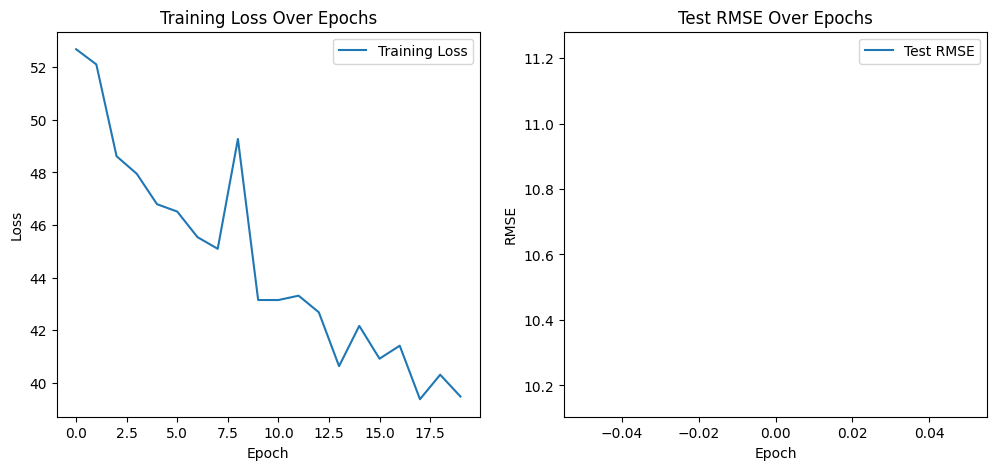

In [32]:
import matplotlib.pyplot as plt

# Plot the loss and RMSE
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE Over Epochs')
plt.legend()

plt.show()
